In [52]:
import bayes3d as b
import os
import glob
import nvsmi
from tqdm import tqdm
import numpy as np
import jax
import functools
import jax.numpy as jnp
from jax.debug import print as jprint
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL
%matplotlib inline

In [53]:
def get_rating_from_data(data):
    num_objects = data[-1]['poses'].shape[0]
    # physics data
    phy_data = []
    for i in range(num_objects):
        phy_data.append([x['physics_weights'][i] if len(x['physics_weights']) > i else np.nan for x in data])
    LR_values = [[] for _ in range(num_objects)]
    for idx in tqdm(range(len(data))):
        # find num of known objects
        num_known_objs = data[idx]['poses'].shape[0]
        # find seg_ids of objects
        seg = data[idx]['gt_seg']
        object_seg_ids = np.unique(seg[data[idx]['object_mask']])
        # find pixel centroid based pose of each segment based on inferred depth
        seg_id_to_pos = {}
        for seg_id in object_seg_ids:
            ii, jj = np.where(seg == seg_id)
            i_med = int(np.median(ii))
            j_med = int(np.median(jj))
            seg_id_to_pos[seg_id] = data[idx]['rerendered_spliced'][i_med, j_med]
        # find associations with seg_id for each known_id
        known_id_to_seg_id = {}
        mutable_known_ids = [x for x in range(num_known_objs)]
        # for each segmented object (which can be seen)
        for seg_id in object_seg_ids:
            # if we have at least one unassociated object model
            if len(mutable_known_ids) > 0:
                # inferred_pos = data[idx]['poses'][known_id,...][:3,3]
                seg_pos = seg_id_to_pos[seg_id]
                inferred_positions = [data[idx]['poses'][known_id,...][:3,3] for known_id in mutable_known_ids]
                dists = [np.linalg.norm(inferred_pos - seg_pos) for inferred_pos in inferred_positions]
                associated_known_id = mutable_known_ids[np.argmin(dists)]
                known_id_to_seg_id[associated_known_id] = seg_id
                mutable_known_ids.remove(associated_known_id)
        for known_id in range(num_objects):
            if known_id <= num_known_objs and known_id in known_id_to_seg_id:
                ob_mask = seg == known_id_to_seg_id[known_id]
                obj_density = np.mean(data[idx]['3dp3_weights'][ob_mask])
                if idx == 140:
                    print(data[idx]['3dp3_weights'][ob_mask])
                LR_values[known_id].append(obj_density)
            else:
                LR_values[known_id].append(np.nan)
    phy_mins = [np.nanmin(x) for x in phy_data]
    LR_mins = [np.nanmin(x) for x in LR_values]
    phy_fail = any([np.sum([x < 0 for x in dta]) >= 2 for dta in phy_data])
    LR_fail = any([len(x) > 7 for x in LR_values]) and any([x < -2.2 for x in LR_mins])
    output = {
        'phy_data' : phy_data,
        'LR_values' : LR_values,
        'phy_mins' : phy_mins,
        'LR_mins' : LR_mins,
        'LR_fail' : LR_fail,
        'phy_fail' : phy_fail,
        'pass' : not phy_fail and not LR_fail
    }
    return output

In [54]:
def display_mcs_video(images, framerate=30):
    frames = [b.get_rgb_image(images[i].rgb) for i in range(len(images))]
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(frames))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=True)
    return HTML(anim.to_html5_video())

def display_video(frames, framerate=30):
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(frames))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=True)
    return HTML(anim.to_html5_video())

def make_plot(x,y, xlabel, ylabel, title = ''):
    plt.clf()
    color = np.array([229, 107, 111])/255.0
    plt.plot(x,y, color=color)
    # plt.yscale("log")
    plt.title(title)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.tight_layout()
    plt.show()
    
def get_gpu_mem():
    if len(nvsmi.get_gpu_processes()) > 0:
        return nvsmi.get_gpu_processes()[0].used_memory
    else:
        return 0.0

class RGBD(object):
    def __init__(self, rgb, depth, camera_pose, intrinsics, segmentation=None):
        """RGBD Image
        
        Args:
            rgb (np.array): RGB image
            depth (np.array): Depth image
            camera_pose (np.array): Camera pose. 4x4 matrix
            intrinsics (b.camera.Intrinsics): Camera intrinsics
            segmentation (np.array): Segmentation image
        """
        self.rgb = rgb
        self.depth = depth
        self.camera_pose = camera_pose
        self.intrinsics = intrinsics
        self.segmentation  = segmentation

def splice_image_parallel(rendered_object_image, obs_image_complement):
    keep_masks = jnp.logical_or(
        (rendered_object_image[:,:,:,2] <= obs_image_complement[None, :,:, 2]) * 
        rendered_object_image[:,:,:,2] > 0.0
        ,
        (obs_image_complement[:,:,2] == 0)[None, ...]
    )[...,None]
    rendered_images = keep_masks * rendered_object_image + (1.0 - keep_masks) * obs_image_complement
    return rendered_images

In [55]:
@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,3,4,),
)
def gausssian_mixture_per_pixel(
    ij,
    data_xyz: jnp.ndarray,
    model_xyz: jnp.ndarray,
    filter_size: int,
    r
):
    dists = data_xyz[ij[0], ij[1], :3] - jax.lax.dynamic_slice(model_xyz, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    probs = (jax.scipy.stats.norm.pdf(dists, loc=0, scale=r)).prod(-1).sum()
    return probs
    
def gaussian_mixture_image(
    obs_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    r
):
    filter_size = 3
    num_latent_points = obs_xyz.shape[1] * obs_xyz.shape[0]
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(obs_xyz.shape[1]), jnp.arange(obs_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    probs = gausssian_mixture_per_pixel(indices, obs_xyz, rendered_xyz_padded, filter_size, r)
    return probs

gaussian_mixture_image_jit = jax.jit(gaussian_mixture_image)

def threedp3_likelihood(
    obs_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    r,
    outlier_prob,
    outlier_volume,
):
    num_latent_points = obs_xyz.shape[1] * obs_xyz.shape[0]
    probs = gaussian_mixture_image(obs_xyz, rendered_xyz, r)
    probs_with_outlier_model = probs * (1.0 - outlier_prob) / num_latent_points   + outlier_prob / outlier_volume
    return jnp.log(probs_with_outlier_model).sum()

def threedp3_likelihood_image(
    obs_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    r,
    outlier_prob,
    outlier_volume,
):
    num_latent_points = obs_xyz.shape[1] * obs_xyz.shape[0]
    probs = gaussian_mixture_image(obs_xyz, rendered_xyz, r)
    probs_with_outlier_model = probs * (1.0 - outlier_prob) / num_latent_points   + outlier_prob / outlier_volume
    return jnp.log(probs_with_outlier_model)

threedp3_likelihood_parallel = jax.vmap(threedp3_likelihood, in_axes=(None, 0, None, None, None))
threedp3_likelihood_parallel_jit = jax.jit(threedp3_likelihood_parallel)
threedp3_likelihood_jit = jax.jit(threedp3_likelihood)
threedp3_likelihood_image_jit = jax.jit(threedp3_likelihood_image)
threedp3_likelihood_with_r_parallel_jit = jax.jit(
    jax.vmap(threedp3_likelihood_parallel, in_axes=(None, None, 0, None, None)),
)

In [56]:
def load_mcs_scene_data(scene_name = "passive_physics_shape_constancy_0001_01", scene_dir = "../../../../../physics_npzs"):
    images = np.load(scene_dir + "/{}.npz".format(scene_name),allow_pickle=True)["arr_0"]
    images = images[85:] # change this
    return images

In [57]:
def get_object_mask(point_cloud_image, segmentation, segmentation_ids):
    object_mask = jnp.zeros(point_cloud_image.shape[:2])
    object_ids = []
    for id in segmentation_ids:
        point_cloud_segment = point_cloud_image[segmentation == id]
        bbox_dims, pose = b.utils.aabb(point_cloud_segment)
        is_occluder = jnp.logical_or(jnp.logical_or(jnp.logical_or(jnp.logical_or(
            (bbox_dims[0] < 0.1),
            (bbox_dims[1] < 0.1)),
            (bbox_dims[1] > 1.1)),
            (bbox_dims[0] > 1.1)),
            (bbox_dims[2] > 2.1)
        )
        if not is_occluder:
            object_mask += (segmentation == id)
            object_ids.append(id)

    object_mask = jnp.array(object_mask) > 0
    return object_ids, object_mask

def in_camera_view(renderer, known_id, pose):
    """ Check if pose point is in camera view """
    # pose is assumed to be in camera frame
    return jnp.mean(renderer.render(pose[None,...], jnp.array([known_id]))[...,2]) < WALL_Z
    

def physics_prior(proposed_pose, physics_estimated_pose):
    proposed_pos = proposed_pose[:3,3]
    physics_estimated_pos = physics_estimated_pose[:3,3]
    return jax.scipy.stats.multivariate_normal.logpdf(
        proposed_pos, physics_estimated_pos, jnp.diag(jnp.array([0.02, 0.02, 0.02]))
    )

physics_prior_parallel_jit = jax.jit(jax.vmap(physics_prior, in_axes=(0, None)))
physics_prior_parallel = jax.vmap(physics_prior, in_axes=(0, None))
physics_prior_jit = jax.jit(physics_prior)

# @functools.partial(
#     jax.jit,
#     static_argnums = (4)
# )
def estimate_best_physics_pose(all_poses, bbox_dims, T, known_id, tstep = 1.0/20.0, camera_pose = None):

    camera_pose = CAM_POSE_CV2
    # Assuming all poses are in camera frame
    # PHYSICS IS IN 20FPS (from step metadata)

    # extract x-y-z positions
    # T-1 
    prev_pose = all_poses[T-1][known_id,...]
    prev_pos = prev_pose[:3,3]
    # if this object existed 2 timesteps back
    if T > 1 and all_poses[T-2].shape[0] > known_id:
        # T-2
        prev_prev_pose =  all_poses[T-2][known_id,...]
    else:
        return prev_pose
        # T-1 = T-2
        # prev_prev_pose =  all_poses[T-1][known_id,...]

    prev_prev_pos = prev_prev_pose[:3,3]

    # find X-Y-Z velocity change

    # I1 & I2 -> find simple difference in world frame + check if object 
    # is on the floor and force it to have no downward vector
    # conversions to world frame
    prev_prev_pos_world = camera_pose[:3,:] @ jnp.concatenate([prev_prev_pos, 1], axis = None)
    prev_pos_world = camera_pose[:3,:] @ jnp.concatenate([prev_pos, 1], axis = None)
    # Note: VELOCITY IS REAL VELOCITY TIMES 1/20 (time step)
    vel_pos_world = prev_pos_world - prev_prev_pos_world

    # artificially curb the velocity of obj in world Y axis
    vel_pos_world = vel_pos_world.at[1].set(0.25 * vel_pos_world[1])

    # if object is on ground (and has upward vel), it should not have an upwards velocity (no bounce assumption)
    vel_pos_world = jax.lax.cond(
        jnp.logical_and(
            jnp.less_equal(prev_pos_world[2] - 0.5*bbox_dims[1], 0.1 * bbox_dims[1]),
            jnp.less(0, vel_pos_world[2])
        ),
        lambda x: x.at[2].set(0),
        lambda x: x,
        vel_pos_world)

    # if object is NOT on ground (and has upward vel), it should reduce it by the right amount via gravity
    vel_pos_world = jax.lax.cond(
        jnp.less(0.1 * bbox_dims[1], prev_pos_world[2] - 0.5*bbox_dims[1]),
        lambda x: x.at[2].set(vel_pos_world[2] + 3 * (0.5 * (-9.81) * (tstep)**2)), # multiply by 5
        lambda x: x,
        vel_pos_world)    

    pred_pos_world = prev_pos_world + vel_pos_world

    # check if bottom of object is below floor (AFTER) 
    object_bottom = pred_pos_world[2] - 0.5*bbox_dims[1]
    pred_pos_world = jax.lax.cond(jnp.less_equal(object_bottom, 0.01 * bbox_dims[1]),
        lambda x: x.at[2].set(0.5*bbox_dims[1]),
        lambda x: x,
        pred_pos_world)

    pred_pos = jnp.linalg.inv(camera_pose)[:3,:] @ jnp.concatenate([pred_pos_world, 1], axis = None)
    
    # I1 -> Integrate X-Y-Z forward to current time step
    # NO ROTATION CHANGE

    physics_estimated_pose = jnp.copy(prev_pose) # orientation is the same
    physics_estimated_pose = physics_estimated_pose.at[:3,3].set(pred_pos)

    return physics_estimated_pose



WALL_Z = 14.5

CAM_POSE = np.array([[ 1,0,0,0],
[0,0,-1,-4.5],
[ 0,1,0,1.5],
[ 0,0,0,1]])
World2Cam = np.linalg.inv(CAM_POSE)
World2Cam[1:3] *= -1
CAM_POSE_CV2 = np.linalg.inv(World2Cam)

In [95]:
class PhysicsServer():
    def __init__(self):
        pass

    def reset(self, intrinsics):
        self.original_intrinsics = intrinsics
        intrinsics = b.camera.scale_camera_parameters(self.original_intrinsics, 0.5)
        intrinsics = b.Intrinsics(
            intrinsics.height, intrinsics.width,
            intrinsics.fx,
            intrinsics.fy,
            intrinsics.cx,
            intrinsics.cy,
            intrinsics.near,
            WALL_Z
        )
        self.intrinsics = intrinsics
        
        self.ALL_OBJECT_POSES = [jnp.zeros((0, 4, 4))]
        self.renderer = b.Renderer(self.intrinsics)
        self.t = 0
        self.first_appearance = []

        dx  = 0.7
        dy = 0.7
        dz = 0.7
        gridding1 = b.utils.make_translation_grid_enumeration(
            -dx, -dy, -dz, dx, dy, dz, 21,15,15
        )
        self.gridding = [gridding1]
        self.plausibility = [0.0]
        self.violation_locations = [[]]
        self.images = []
        self.activate_physics_prior = []
        # self.physics_activation_delay = 0

        return []

    def update(self, image, data):

        # print("Z1: ", get_gpu_mem())

        
        self.t += 1
        self.images.append(image)

        t = self.t
        images = self.images
        intrinsics = self.intrinsics
        gridding = self.gridding
        renderer = self.renderer
        plausibility = self.plausibility[-1]
        # if self.physics_activation_delay > 0:
        #     self.physics_activation_delay -= 1
        #     if self.physics_activation_delay == 0:
        #         self.activate_physics_prior = True

        ALL_OBJECT_POSES = self.ALL_OBJECT_POSES


        R_SWEEP = jnp.array([0.02])
        OUTLIER_PROB=0.05
        OUTLIER_VOLUME=1.0

        depth = b.utils.resize(image.depth, intrinsics.height, intrinsics.width)
        point_cloud_image = b.t3d.unproject_depth(depth, intrinsics)

        # print("Z2: ", get_gpu_mem())

        segmentation = b.utils.resize(image.segmentation, intrinsics.height, intrinsics.width)
        segmentation_ids = jnp.unique(segmentation)

        object_ids, object_mask = get_object_mask(point_cloud_image, segmentation, segmentation_ids)
        depth_complement = depth * (1.0 - object_mask) + intrinsics.far * (object_mask)
        point_cloud_image_complement = b.t3d.unproject_depth(depth_complement, intrinsics)
        # print("Z3: ", get_gpu_mem())

        OBJECT_POSES = jnp.array(ALL_OBJECT_POSES[t-1])
        pre_num_active_objects = OBJECT_POSES.shape[0]
        final_physics_weight = []
        all_pose_proposals = []
        all_weights = []
        all_weights_3dp3 = []
        all_weights_physics = []
        physics_estimated_poses = []

        # print("Z4: ", get_gpu_mem())

        # find closest known ids to each seg id
        known_id_to_seg_id = {}
        mutable_known_ids = list(range(pre_num_active_objects))
        for seg_id in object_ids:
            min_dist = 1e9
            closest_known_id = None
            _, center_pose = b.utils.aabb(point_cloud_image[segmentation==seg_id])
            for known_id in mutable_known_ids:
                dist = jnp.linalg.norm(center_pose[:3,3] - OBJECT_POSES[known_id, :3,3])
                #  must be within a reasonable distance (e.g. max grid size)
                # otherwise anything new in the scene can be snapped by another object
                if dist < 0.7 and dist < min_dist:
                    min_dist = dist
                    closest_known_id = known_id
            if closest_known_id != None:
                known_id_to_seg_id[closest_known_id] = seg_id
                mutable_known_ids.remove(closest_known_id)


        for known_id in range(pre_num_active_objects):            

            current_pose_estimate = OBJECT_POSES[known_id,...]

            for gridding_iter in range(len(gridding)):
                num_proposals = gridding[gridding_iter].shape[0]
                all_pose_proposals = [
                    jnp.einsum("aij,jk->aik", 
                        gridding[gridding_iter],
                        current_pose_estimate,
                    )
                ]

                if known_id in known_id_to_seg_id:
                    closest_seg_id = known_id_to_seg_id[known_id]
                else:
                    closest_seg_id = None
                # print("B: ", get_gpu_mem())

                if gridding_iter == 0 and closest_seg_id != None:
                    # in case existing object model reappears magically somewhere else
                    # however the physics model will never allow for this, so we deactivate it
                    _, center_pose = b.utils.aabb(point_cloud_image[segmentation==closest_seg_id])
                    # if jnp.linalg.norm(center_pose[:3,3] - current_pose_estimate[:3,3]) > (3*0.7**2)**(0.5) and in_camera_view(renderer,known_id,current_pose_estimate):
                    if in_camera_view(renderer,known_id,current_pose_estimate):
                        all_pose_proposals.append(
                            jnp.einsum("aij,jk->aik", 
                                gridding[gridding_iter],
                                center_pose,
                            )
                        )

                all_pose_proposals = jnp.vstack(all_pose_proposals)

                # Find the complement to this seg_id
                if closest_seg_id != None:
                    seg_mask = segmentation == closest_seg_id
                    obj_depth_complement = depth * (1.0 - seg_mask) + intrinsics.far * (seg_mask)
                    obj_point_cloud_image_complement = b.t3d.unproject_depth(obj_depth_complement, intrinsics)
                else:
                    obj_point_cloud_image_complement = jnp.copy(point_cloud_image_complement)
                    
                all_weights_ = []
                all_weights_3dp3_ = []
                all_weights_physics_ = []

                physics_estimated_pose = estimate_best_physics_pose(ALL_OBJECT_POSES, renderer.model_box_dims[known_id], t, known_id)
                physics_estimated_poses.append(physics_estimated_pose)

                # calculate number of array_splits needed
                num_batches = int(8 * all_pose_proposals.shape[0] / gridding[gridding_iter].shape[0])
                
                for i, batch in enumerate(jnp.array_split(all_pose_proposals,num_batches)):
                    #########################################################################################
                    # print("E{}: ".format(i+1), get_gpu_mem())
                    rendered_images = renderer.render_many(batch[:,None,...], jnp.array([known_id]))[...,:3]
                    # print("F{}: ".format(i+1), get_gpu_mem())
                    rendered_images_spliced = splice_image_parallel(rendered_images, obj_point_cloud_image_complement)
                    # print("G{}: ".format(i+1), get_gpu_mem())

                    weights_3dp3 = threedp3_likelihood_with_r_parallel_jit(
                        point_cloud_image, rendered_images_spliced, R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME
                    ).reshape(-1)

                    if self.activate_physics_prior[known_id]:
                        weights_physics = physics_prior_parallel_jit(
                            batch, physics_estimated_pose
                        ).reshape(-1)
                    else:
                        weights_physics = jnp.zeros(weights_3dp3.shape)

                    del rendered_images
                    del rendered_images_spliced

                    weights = weights_3dp3 + weights_physics
                    all_weights_.append(weights)
                    all_weights_3dp3_.append(weights_3dp3)
                    all_weights_physics_.append(weights_physics)


                # print("H{}: ".format(i+1), get_gpu_mem())

                all_weights_ = jnp.hstack(all_weights_)
                all_weights_3dp3_ = jnp.hstack(all_weights_3dp3_)
                all_weights_physics_ = jnp.hstack(all_weights_physics_)

                # dont apply physics prior to snapping segmented ids
                if all_weights_.shape[0] > num_proposals:
                    all_weights_ = all_weights_.at[num_proposals:].set(all_weights_3dp3_[num_proposals:])

                # Deactivate physics prior fully if the best pose is to snap
                if gridding_iter == 0 and all_weights_.argmax() >= num_proposals:
                    self.activate_physics_prior[known_id] = True
                    # self.physics_activation_delay = 2

                current_pose_estimate = all_pose_proposals[all_weights_.argmax()]

            # print("I: ", get_gpu_mem())

            OBJECT_POSES = OBJECT_POSES.at[known_id].set(current_pose_estimate)
            if self.activate_physics_prior[known_id]:
                final_physics_weight.append(physics_prior_jit(current_pose_estimate, physics_estimated_pose))
            else:
                final_physics_weight.append(jnp.nan)

            all_weights.append(all_weights_)
            all_weights_3dp3.append(all_weights_3dp3_)
            all_weights_physics.append(all_weights_physics_)

            # print("J: ", get_gpu_mem())

        # print("K: ", get_gpu_mem())

        ##########################################################################################
        if pre_num_active_objects > 0:
            rerendered = renderer.render(OBJECT_POSES, jnp.arange(pre_num_active_objects))[...,:3]
        else:
            rerendered = jnp.copy(point_cloud_image)
            # rerendered = rerendered.at[...,-1].set(WALL_Z)
        # print("L: ", get_gpu_mem())

        rerendered_spliced = splice_image_parallel(jnp.array([rerendered]), point_cloud_image_complement)[0]
        # final_weight = b.threedp3_likelihood_per_pixel_jit(
        #                 point_cloud_image, rerendered_spliced, R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME, 3
        #             ).reshape(-1)
        # print("M: ", get_gpu_mem())

        final_3dp3_weight = threedp3_likelihood_image_jit(
                        point_cloud_image, rerendered_spliced, R_SWEEP, OUTLIER_PROB, OUTLIER_VOLUME
                    )

        
        pixelwise_probs = gaussian_mixture_image_jit(point_cloud_image, rerendered_spliced, R_SWEEP)
        # print("N: ", get_gpu_mem())

        object_data = {}
        for seg_id in object_ids:
            object_data[int(seg_id)] = {}
            average_probability = jnp.mean(pixelwise_probs[segmentation == seg_id])
            object_data[int(seg_id)]['ave_prob'] = average_probability

            if pre_num_active_objects > 0 and average_probability > 50.0:
                continue

            num_pixels = jnp.sum(segmentation == seg_id)
            object_data[int(seg_id)]['num_pixels'] = num_pixels
            if num_pixels < 14:
                continue

            rows, cols = jnp.where(segmentation == seg_id)
            distance_to_edge_1 = min(jnp.abs(rows - 0).min(), jnp.abs(rows - intrinsics.height).min())
            distance_to_edge_2 = min(jnp.abs(cols - 0).min(), jnp.abs(cols - intrinsics.width).min())
            object_data[int(seg_id)]['edge_dists'] = (distance_to_edge_1, distance_to_edge_2)
            point_cloud_segment = point_cloud_image[segmentation == seg_id]
            dims, pose = b.utils.aabb(point_cloud_segment)

            BUFFER = 3
            # ASSUMPTION: Objects cannot spontaneously appear out of the middle of an image
            # if an existing object model cannot already fit to it (obj permanence):
            if distance_to_edge_1 < BUFFER or distance_to_edge_2 < BUFFER or (pre_num_active_objects > 0 and distance_to_edge_1 > 40 and distance_to_edge_2 > 40):
                continue

            resolution = 0.01
            voxelized = jnp.rint(point_cloud_segment / resolution).astype(jnp.int32)
            min_z = voxelized[:,2].min()
            depth_val = voxelized[:,2].max() - voxelized[:,2].min()

            front_face = voxelized[voxelized[:,2] <= min_z+20, :]
            slices = [front_face]
            for i in range(depth_val):
                slices.append(front_face + jnp.array([0.0, 0.0, i]))
            full_shape = jnp.vstack(slices) * resolution

            print("Seg ID: ", seg_id, "Prob: ", average_probability, " Pixels: ",num_pixels, " dists: ", distance_to_edge_1, " ", distance_to_edge_2, " Pose: ", pose[:3, 3])

            dims, pose = b.utils.aabb(full_shape)
            # print("before making mesh object", get_gpu_mem())

            mesh = b.utils.make_marching_cubes_mesh_from_point_cloud(
                b.t3d.apply_transform(full_shape, b.t3d.inverse_pose(pose)),
                0.075
            )
            # print("before adding", get_gpu_mem())
            renderer.add_mesh(mesh)
            print("Adding new mesh")
            # print("after adding", get_gpu_mem())

            self.activate_physics_prior.append(True)

            OBJECT_POSES = jnp.concatenate([OBJECT_POSES, pose[None, ...]], axis=0)

        # print("O: ", get_gpu_mem())


        ALL_OBJECT_POSES.append(OBJECT_POSES)

        self.ALL_OBJECT_POSES = ALL_OBJECT_POSES

        violations = []

        POSES = jnp.array(ALL_OBJECT_POSES[t])
        post_num_active_objects = POSES.shape[0]

        num_new_objects = post_num_active_objects - pre_num_active_objects
        if num_new_objects > 0:
            print(f"{num_new_objects} new objects!")
        for new_object_index in range(pre_num_active_objects, post_num_active_objects):
            self.first_appearance.append(t)
            position = POSES[new_object_index,:3,3]
            ################################################################################################
            # jprint("Before render 3: {}", get_gpu_mem())
            new_obj_rerendered = renderer.render(POSES[new_object_index:new_object_index+1], jnp.array([new_object_index]))[...,:3]
            # jprint("After render 3: {}", get_gpu_mem())
            rows, cols = jnp.where(new_obj_rerendered[:,:,2] > 0.0)
            distance_to_edge_1 = min(jnp.abs(rows - 0).min(), jnp.abs(rows - intrinsics.height).min())
            distance_to_edge_2 = min(jnp.abs(cols - 0).min(), jnp.abs(cols - intrinsics.width).min())     
            if distance_to_edge_1 > 15 and  distance_to_edge_2 > 15:
                pixx, pixy= np.array(b.project_cloud_to_pixels(jnp.array([ position]), intrinsics).astype(jnp.int32)[0])
                for t_ in range(t-3):
                    occluded = b.utils.resize(images[t_].depth, intrinsics.height, intrinsics.width)[pixy, pixx] < position[2]
                    if not occluded:
                        pixx, pixy= np.array(b.project_cloud_to_pixels(jnp.array([ position]), intrinsics).astype(jnp.int32)[0]) * 4
                        violations.append({"x": pixx, "y": pixy})
                        plausibility -= 0.1
                        print("Object initialize not near edge! Implausiblepix!")
                        break

        for id_1 in range(post_num_active_objects):
            for id_2 in range(post_num_active_objects):
                if id_1 != id_2:
                    distance = jnp.linalg.norm(POSES[id_1,:3,3] - POSES[id_2,:3,3])
                    if distance < 0.4:
                        pixx, pixy= np.array(b.project_cloud_to_pixels(jnp.array([ POSES[id_1,:3,3]]), intrinsics).astype(jnp.int32)[0]) * 4
                        violations.append({"x": pixx, "y": pixy})
                        plausibility -= 0.1
                        print("Objects too close together! Implausible!")


        for id in range(post_num_active_objects):
            z_delta = POSES[id,:3,3][1] - ALL_OBJECT_POSES[self.first_appearance[id]][id,:3,3][1]
            if z_delta < -0.2:
                pixx, pixy=  np.array(b.project_cloud_to_pixels(jnp.array([ POSES[id,:3,3]]), intrinsics).astype(jnp.int32)[0]) * 4
                violations.append({"x": pixx, "y": pixy})
                plausibility -= 0.05
                print("Objects is not obeying gravity! Implausible!")

            if POSES[id,:3,3][1] > 1.5:
                pixx, pixy= np.array(b.project_cloud_to_pixels(jnp.array([ POSES[id,:3,3]]), intrinsics).astype(jnp.int32)[0]) * 4
                violations.append({"x": pixx, "y": pixy})
                plausibility -= 0.01
                print("Objects inside floor!")

            if POSES[id,:3,3][2] > 13.0:
                pixx, pixy= np.array(b.project_cloud_to_pixels(jnp.array([ POSES[id,:3,3]]), intrinsics).astype(jnp.int32)[0]) * 4
                violations.append({"x": pixx, "y": pixy})
                plausibility -= 0.01
                print("Objects behind wall!")
        # print("P: ", get_gpu_mem())
        data.append({
            't' : t,
            'gt_rgbd' : image,
            'gt_depth' : depth,
            'gt_seg' : segmentation,
            'gt_PCI' : point_cloud_image,
            'seg_ids' : segmentation_ids,
            'obj_ids' : object_ids,
            'object_mask' :object_mask,
            'depth_complement' : depth_complement,
            'PCI_complement' : point_cloud_image_complement,
            'all_pose_proposals' : all_pose_proposals,
            'all_weights_3dp3' : all_weights_3dp3,
            'all_weights_physics' : all_weights_physics,
            'rerendered' : rerendered,
            'rerendered_spliced' : rerendered_spliced,
            '3dp3_weights' : final_3dp3_weight,
            'physics_weights' : final_physics_weight,
            'poses' : POSES,
            'physics_estimated_poses' : physics_estimated_poses,
            'object_data' : object_data, # contains ave_prob
            'pre_num_active_objects' : pre_num_active_objects,
            'post_num_active_objects' : post_num_active_objects,
            'plausibility' : plausibility,
            'violation_locations' : violations
        })

        self.plausibility.append(plausibility)
        self.violation_locations.append(violations)
        return data

    def process_message(self, message):
        (request_type, args) = message
        # print(f"received reqeust {request_type}")
        if request_type == "reset":
            (h,w,fx,fy,cx,cy,near,far) = args
            intrinsics = b.Intrinsics(
                h,w,fx,fy,cx,cy,near,far
            )
            data = self.reset(intrinsics)
            return data
        elif request_type == "update":
            image, data = args
            data = self.update(image, data)
            return data
        elif request_type == "get_info":
            return args
        else:
            print("I HAVE NO IDEA WHAT REQUEST YOU'RE MAKING!")

In [96]:
def run_physics_scene(scene_name, physics_server):
    images = load_mcs_scene_data(scene_name)
    data = physics_server.process_message(("reset",(400,600, 514.2991467983065,514.2991467983065,300.0,200.0,0.009999999776482582,150.0)))
    for i, img in enumerate(images):
        print("Frame number #",i+1)
        data = physics_server.process_message(("update", (img, data)))
        # print(get_gpu_mem())
    output = get_rating_from_data(data)
    # data = physics_server.process_message(("get_info",None))
    physics_server.renderer.cleanup()
    print(get_gpu_mem())
    # backend = jax.lib.xla_bridge.get_backend()
    # for buf in backend.live_buffers(): 
    #     buf.delete()
    print(get_gpu_mem())
    return output, physics_server, data
        

In [124]:
p = PhysicsServer()
_, p, data = run_physics_scene("passive_physics_shape_constancy_0001_06", p)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 224, 1024)
Frame number # 1
Frame number # 2
Frame number # 3
Frame number # 4
Frame number # 5
Frame number # 6
Frame number # 7
Frame number # 8
Frame number # 9
Seg ID:  0 Prob:  12476.295  Pixels:  111  dists:  3   111  Pose:  [-1.1044152 -3.4484177  9.49361  ]
Centering mesh with translation [ 0.00250009 -0.00250001 -0.0100006 ]
Adding new mesh
1 new objects!
Frame number # 10
Seg ID:  3 Prob:  0.0  Pixels:  264  dists:  10   71  Pose:  [ 1.8435225 -2.309073   7.1808558]
Centering mesh with translation [-0.01750001 -0.01250005 -0.01749992]
Adding new mesh
1 new objects!
Frame number # 11
Frame number # 12
Frame number # 13
Frame number # 14
Frame number # 15
Frame number # 16
Frame number # 17
Frame number # 18
Frame number # 19
Frame number # 20
Frame number # 21
Frame number # 22
Frame number # 23
Frame number # 24
Frame number # 25
Frame number # 26
Frame number # 27
Frame number # 28
Frame number # 29
Frame number 

100%|██████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 162.80it/s]


destructor
resources released
Renderer resources and memory cleared.
6970.0
6970.0


In [16]:
phy_paths = "/home/ubuntu/physics_npzs/*.npz"
files = sorted(glob.glob(phy_paths))
files = [f.split("/")[-1].split(".")[0] for f in files][57:]

# run full experiment
p = PhysicsServer()
result = {}
datas = {}
for i, f in enumerate(files):
    print("Before ", get_gpu_mem())
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Scene #{}".format(i+1))
    result[f], p, datas[f] = run_physics_scene(f,p)
    print("After", get_gpu_mem())



In [10]:
result

{'passive_physics_object_permanence_0001_01': {'phy_data': [[nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    nan,
    Array(2.0087185, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088719, dtype=float32),
    Array(3.088

In [125]:
rgb = [b.resize_image(b.get_rgb_image(x["gt_rgbd"].rgb),p.intrinsics.height,p.intrinsics.width) for x in data]
depth = [b.get_depth_image(x['gt_depth']) for x in data]
depth_complement = [b.get_depth_image(x['depth_complement']) for x in data]
rerendered = [b.get_depth_image(x['rerendered'][...,2]) for x in data]
rerendered_spliced = [b.get_depth_image(x['rerendered_spliced'][...,2]) for x in data]

viz_images = [
    b.viz.multi_panel(
        [r, d, dc, rr, rrs],
        labels = ["RGB", "Depth (GT)", "Depth (Compl)", "Rerendered", "Rerendered (Spliced)"],
        label_fontsize=10,
        bottom_text = "fillspace",
        bottom_fontsize = 60
    )
    for (r, d, dc, rr, rrs) in zip(rgb, depth, depth_complement,rerendered,rerendered_spliced)
]
display_video(viz_images)

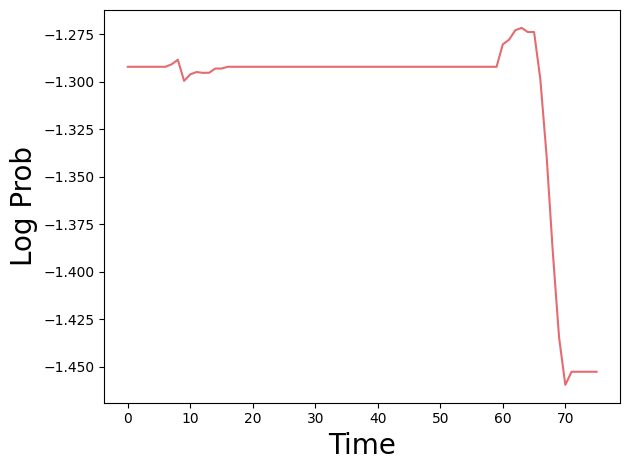

In [131]:
make_plot(np.arange(len(data)), [float(x["3dp3_weights"].sum().reshape(-1) / (p.intrinsics.height * p.intrinsics.width)) for x in data],"Time", "Log Prob")

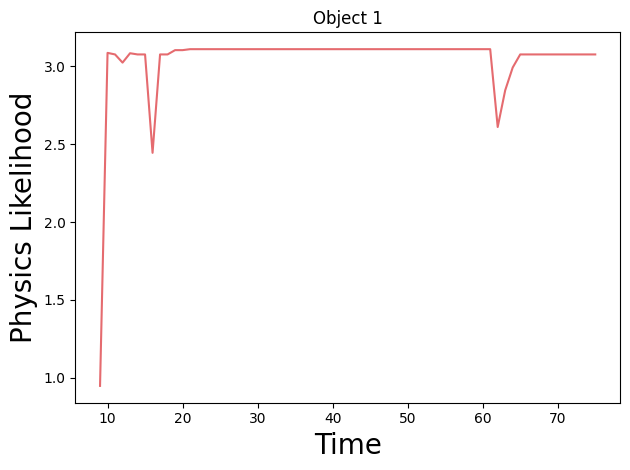

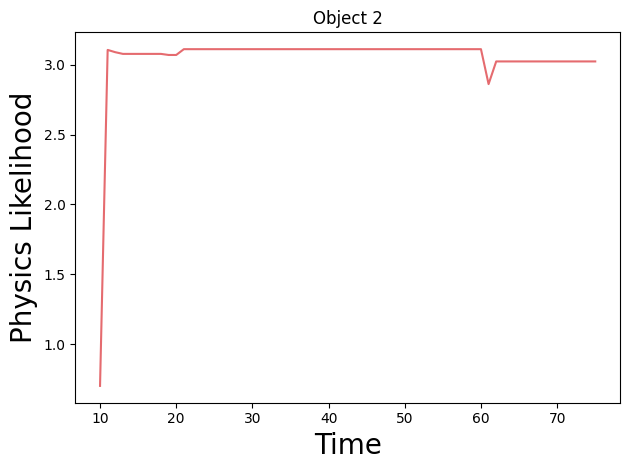

In [132]:
num_objects = data[-1]['poses'].shape[0]
for i in range(num_objects):
    make_plot(np.arange(len(data)), [x['physics_weights'][i] if len(x['physics_weights']) > i else np.nan for x in data],"Time", "Physics Likelihood", title = "Object {}".format(i+1))

In [104]:
dta = [x['physics_weights'][0] if len(x['physics_weights']) > 0 else np.nan for x in data]
dta 

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 Array(0.9481268, dtype=float32),
 Array(3.0874784, dtype=float32),
 Array(3.0773869, dtype=float32),
 Array(3.0248647, dtype=float32),
 Array(3.0850782, dtype=float32),
 Array(3.077386, dtype=float32),
 Array(3.077386, dtype=float32),
 Array(2.4452617, dtype=float32),
 Array(3.077386, dtype=float32),
 Array(3.0773861, dtype=float32),
 Array(3.1049578, dtype=float32),
 Array(3.1049578, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.111219, dtype=float32),
 Array(3.1112

In [56]:
idxx = 9
idx_b = np.argmax(data[idxx]['all_weights_3dp3'][0] + data[idxx]['all_weights_physics'][0])
print(idx_b)
print(data[idxx]['all_pose_proposals'][idx_b])
print(data[idxx]['all_weights_3dp3'][0][idx_b])
print(data[idxx]['all_weights_physics'][0][idx_b])
# 1728, 2365, 7402
print(data[idxx]['all_weights_3dp3'][0][1728])
print(data[idxx]['all_weights_physics'][0][1728])

7402
[[ 1.         0.         0.        -1.1073453]
 [ 0.         1.         0.        -3.1613631]
 [ 0.         0.         1.         9.582194 ]
 [ 0.         0.         0.         1.       ]]
-106023.35
0.9481268
-106074.766
-1.8887753


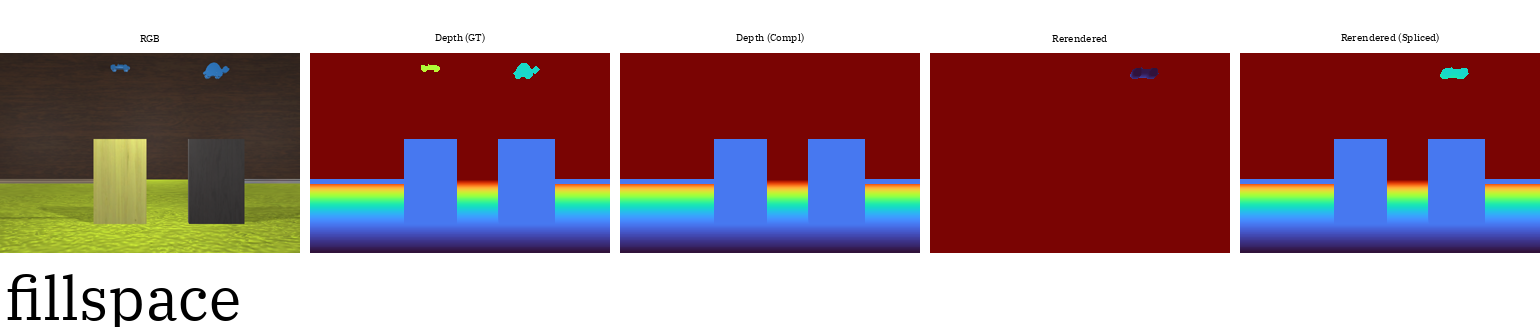

In [36]:
# print((CAM_POSE_CV2 @ data[8]['poses'][0])[:3,3])
# print((CAM_POSE_CV2 @ data[9]['all_pose_proposals'][7402])[:3,3])
# data[9]['poses'][0][:3,3]
viz_images[9]

In [64]:
idx = 70
print(data[idx]['pre_num_active_objects'])
print(data[idx]['post_num_active_objects'])
print(data[idx]['all_pose_proposals'].shape)

2
2
(9450, 4, 4)


In [133]:
#######################
# First object first frame will have high prob as it is based on observed Image
# Second object onwards will have it at low prob from the first frame itself
########################

num_objects = data[-1]['poses'].shape[0]
LR_values = [[] for _ in range(num_objects)]
for idx in tqdm(range(len(data))):
    # find num of known objects
    num_known_objs = data[idx]['poses'].shape[0]
    # find seg_ids of objects
    seg = data[idx]['gt_seg']
    object_seg_ids = np.unique(seg[data[idx]['object_mask']])
    # find pixel centroid based pose of each segment based on inferred depth
    seg_id_to_pos = {}
    for seg_id in object_seg_ids:
        ii, jj = np.where(seg == seg_id)
        i_med = int(np.median(ii))
        j_med = int(np.median(jj))
        seg_id_to_pos[seg_id] = data[idx]['rerendered_spliced'][i_med, j_med]
    # find associations with seg_id for each known_id
    known_id_to_seg_id = {}
    mutable_known_ids = [x for x in range(num_known_objs)]
    # for each segmented object (which can be seen)
    for seg_id in object_seg_ids:
        # if we have at least one unassociated object model
        if len(mutable_known_ids) > 0:
            # inferred_pos = data[idx]['poses'][known_id,...][:3,3]
            seg_pos = seg_id_to_pos[seg_id]
            inferred_positions = [data[idx]['poses'][known_id,...][:3,3] for known_id in mutable_known_ids]
            dists = [np.linalg.norm(inferred_pos - seg_pos) for inferred_pos in inferred_positions]
            associated_known_id = mutable_known_ids[np.argmin(dists)]
            known_id_to_seg_id[associated_known_id] = seg_id
            mutable_known_ids.remove(associated_known_id)
    for known_id in range(num_objects):
        if known_id <= num_known_objs and known_id in known_id_to_seg_id:
            ob_mask = seg == known_id_to_seg_id[known_id]
            obj_density = np.mean(data[idx]['3dp3_weights'][ob_mask])
            LR_values[known_id].append(obj_density)
        else:
            LR_values[known_id].append(np.nan)

100%|██████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 165.00it/s]


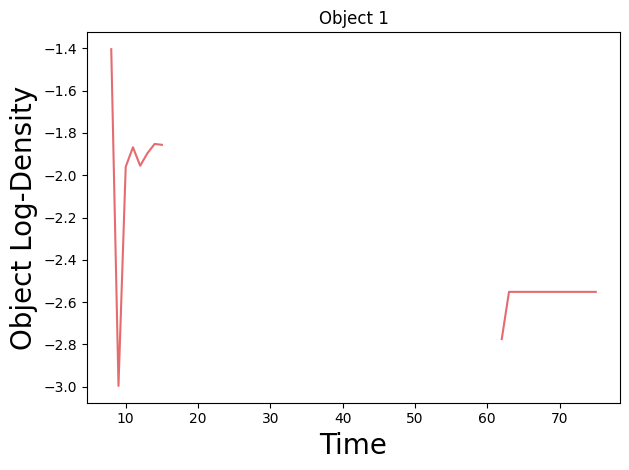

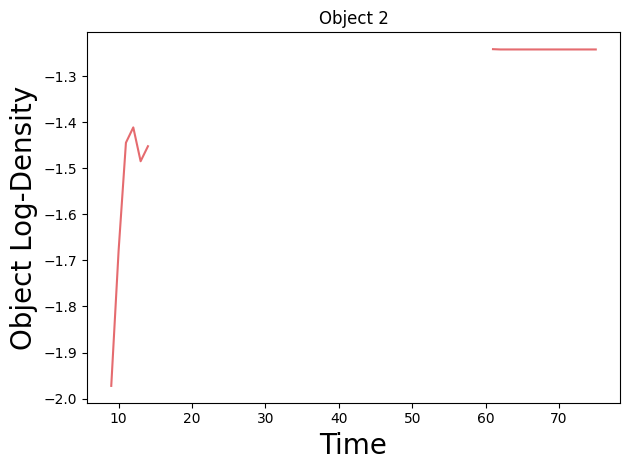

In [134]:
for i in range(num_objects):
    make_plot(np.arange(len(data)), [x for x in LR_values[i]],"Time", "Object Log-Density", title="Object {}".format(i+1))

In [130]:
LR_values[0]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 Array(-1.4038836, dtype=float32),
 Array(-2.9957323, dtype=float32),
 Array(-1.9596757, dtype=float32),
 Array(-1.8676728, dtype=float32),
 Array(-1.9549884, dtype=float32),
 Array(-1.8959278, dtype=float32),
 Array(-1.8519039, dtype=float32),
 Array(-1.8560874, dtype=float32),
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 Array(-2.774196, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.5512898, dtype=float32),
 Array(-2.55

In [22]:
for i in range(11,len(data)):
    world_pose = CAM_POSE_CV2 @ data[i]['poses'][0]
    physics_est_pose = CAM_POSE_CV2 @ data[i]['physics_estimaPted_poses'][0]
    print(i, physics_est_pose[:3,3], world_pose[:3,3])
 


KeyError: 'physics_estimaPted_poses'

In [26]:
idx = 9
world_pose = CAM_POSE_CV2 @ data[idx]['poses'][0]
world_pos = world_pose[:3,3]
print("World Pos: ", world_pos, np.max(data[idx]['all_weights_3dp3'][0]))
for i in range(data[idx]['all_pose_proposals'].shape[0]):
    prop = CAM_POSE_CV2 @ data[idx]['all_pose_proposals'][i]
    if prop[0,3] == -1.105 and prop[1,3] == 5.0650005:
        print(i, prop[:3,3], data[idx]['all_weights_3dp3'][0][i], data[idx]['all_weights_physics'][0][i])

World Pos:  [-1.105      4.8650007  5.3549995] -45601.203


2355 [-1.105      5.0650005  5.6549997] -45601.203 -9.138773
2356 [-1.105      5.0650005  5.555    ] -45601.203 -5.8887787
2357 [-1.105      5.0650005  5.455    ] -45601.203 -3.1387806
2358 [-1.105      5.0650005  5.3549995] -45655.477 -0.88877773
2359 [-1.105      5.0650005  5.255    ] -45760.367 0.8612194
2360 [-1.105      5.0650005  5.1549997] -45857.46 2.1112185
2361 [-1.105      5.0650005  5.055    ] -45923.42 2.8612194
2362 [-1.105      5.0650005  4.955    ] -45915.64 3.111219
2363 [-1.105      5.0650005  4.855    ] -45823.293 2.8612194
2364 [-1.105      5.0650005  4.755    ] -45654.664 2.1112185
2365 [-1.105      5.0650005  4.6549997] -45646.79 0.8612194
2366 [-1.105      5.0650005  4.555    ] -45761.254 -0.8887825
2367 [-1.105      5.0650005  4.455    ] -45877.027 -3.1387806
2368 [-1.105      5.0650005  4.3549995] -45892.344 -5.8887844
2369 [-1.105      5.0650005  4.255    ] -45888.46 -9.138781


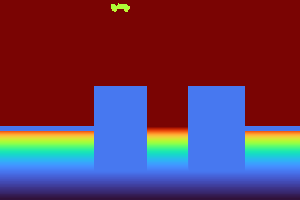

In [29]:
b.get_depth_image(data[8]['gt_PCI'][...,2])

In [30]:
print(data[8]['pre_num_active_objects'])
print(data[8]['post_num_active_objects'])

0
1


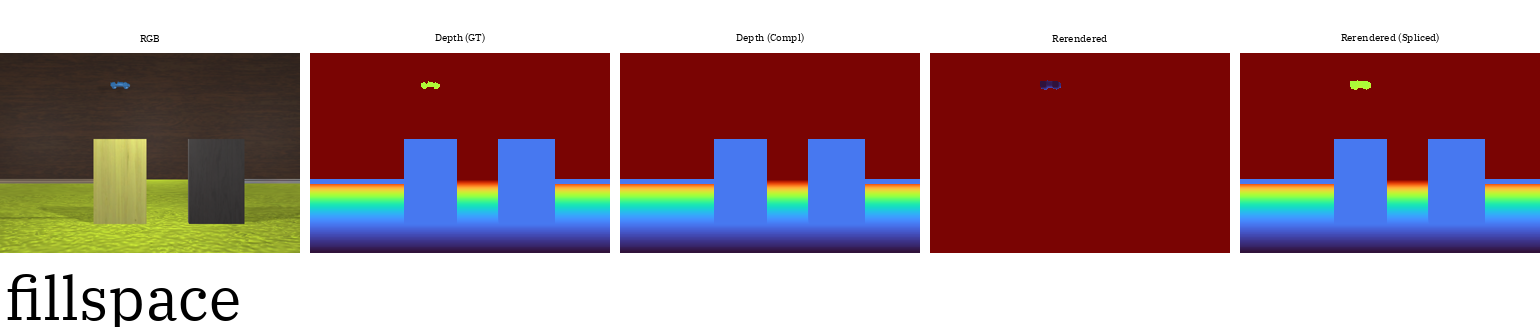

In [44]:
viz_images[11]

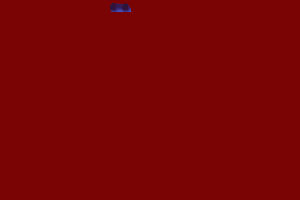

In [36]:
b.get_depth_image(data[8]['rerendered'][...,2])

In [3]:
phy_paths = "/home/ubuntu/physics_npzs/*.npz"
files = sorted(glob.glob(phy_paths))
files = [f.split("/")[-1].split(".")[0] for f in files]

In [7]:
files[42:]

['passive_physics_object_permanence_0001_01',
 'passive_physics_object_permanence_0001_02',
 'passive_physics_object_permanence_0001_03',
 'passive_physics_object_permanence_0001_10',
 'passive_physics_object_permanence_0001_11',
 'passive_physics_object_permanence_0001_12',
 'passive_physics_object_permanence_0001_19',
 'passive_physics_object_permanence_0001_20',
 'passive_physics_object_permanence_0001_21',
 'passive_physics_object_permanence_0001_28',
 'passive_physics_object_permanence_0001_29',
 'passive_physics_object_permanence_0001_34',
 'passive_physics_object_permanence_0001_35',
 'passive_physics_object_permanence_0001_40',
 'passive_physics_object_permanence_0001_41',
 'passive_physics_shape_constancy_0001_01',
 'passive_physics_shape_constancy_0001_02',
 'passive_physics_shape_constancy_0001_05',
 'passive_physics_shape_constancy_0001_06',
 'passive_physics_shape_constancy_0001_07',
 'passive_physics_spatio_temporal_continuity_0001_01',
 'passive_physics_spatio_temporal_c

In [14]:
[x["phy_mins"] for x in result.values()]

[[-3.449101448059082],
 [1.1287193298339844],
 [-3.449101448059082],
 [-1.1377897262573242],
 [-13.041891098022461],
 [],
 [1.5087170600891113],
 [0.0487213134765625],
 [0.8612194061279297]]

In [17]:
list(result.values())[4]['LR_values']

[[nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  Array(-2.4724941, dtype=float32),
  Array(-2.4998045, dtype=float32),
  Array(-2.4927378, dtype=float32),
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  Array(-2.8066747, dtype=float32),
  Array(-2.2527602, dtype=float32),
  Array(-2.2267864, dtype=float32),
  Array(-2.271159, dtype=float32),
  Array(-2.171664, dtype=float32),
  Array(-2.2441301, dtype=float32),
  Array(-2.136719, dtype=float32),
  Array(-2.2628348, dtype=float32),
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan

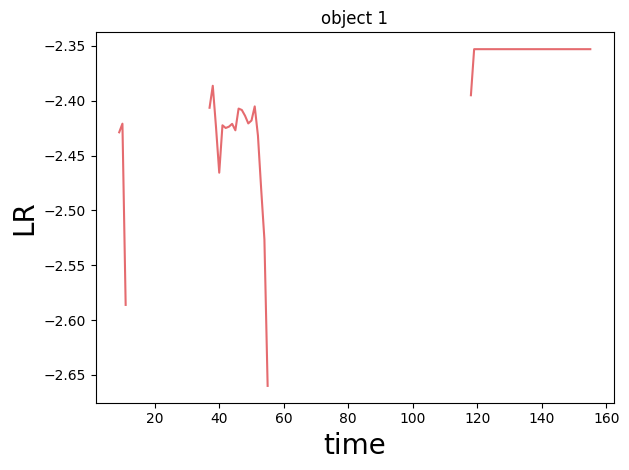

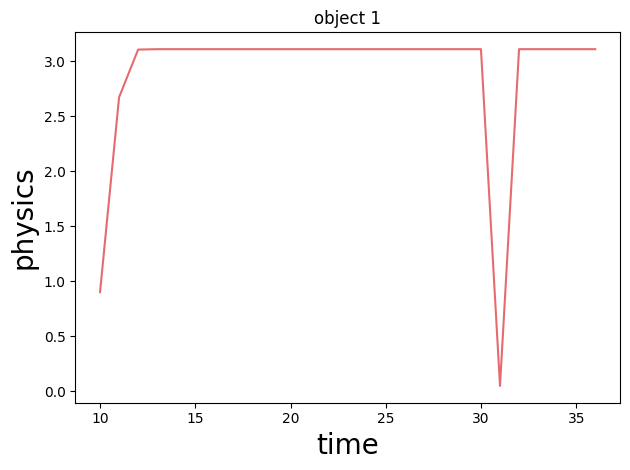

In [39]:
idx = 7
for i in range(len(list(result.values())[idx]['LR_values'])):
    d = list(result.values())[idx]['LR_values'][i]
    make_plot(np.arange(len(d)), d, 'time', 'LR', 'object {}'.format(i+1))
for i in range(len(list(result.values())[idx]['phy_data'])):
    d = list(result.values())[idx]['phy_data'][i]
    make_plot(np.arange(len(d)), d, 'time', 'physics', 'object {}'.format(i+1))

In [40]:
data = list(datas.values())[idx]
rgb = [b.resize_image(b.get_rgb_image(x["gt_rgbd"].rgb),p.intrinsics.height,p.intrinsics.width) for x in data]
depth = [b.get_depth_image(x['gt_depth']) for x in data]
depth_complement = [b.get_depth_image(x['depth_complement']) for x in data]
rerendered = [b.get_depth_image(x['rerendered'][...,2]) for x in data]
rerendered_spliced = [b.get_depth_image(x['rerendered_spliced'][...,2]) for x in data]

viz_images = [
    b.viz.multi_panel(
        [r, d, dc, rr, rrs],
        labels = ["RGB", "Depth (GT)", "Depth (Compl)", "Rerendered", "Rerendered (Spliced)"],
        label_fontsize=10,
        bottom_text = "fillspace",
        bottom_fontsize = 60
    )
    for (r, d, dc, rr, rrs) in zip(rgb, depth, depth_complement,rerendered,rerendered_spliced)
]
display_video(viz_images)

In [14]:
xx = jnp.eye(4)
xx = xx.at[:3,3].set(jnp.array([0,0,5]))
yy = p.renderer.render(xx[None,...],jnp.array([0]))
yy[...,2]


Array([[14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5],
       [14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5],
       [14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5],
       ...,
       [14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5],
       [14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5],
       [14.5, 14.5, 14.5, ..., 14.5, 14.5, 14.5]], dtype=float32)

In [15]:
if jnp.mean(yy[...,2]) < WALL_Z:
    print("hehe")
else:
    print("hoho")

hehe


In [10]:
[x['pass'] for x in result.values()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [5]:
import numpy as np
np.nan == 0

False

In [12]:
backend = jax.lib.xla_bridge.get_backend()


In [16]:
print(dir(backend))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'buffer_from_pyval', 'compile', 'create_channel_handle', 'create_device_to_host_channel_handle', 'create_host_to_device_channel_handle', 'defragment', 'deserialize_executable', 'device_count', 'devices', 'emit_python_callback', 'get_default_device_assignment', 'get_emit_python_callback_descriptor', 'heap_profile', 'host_id', 'live_arrays', 'live_buffers', 'live_executables', 'local_device_count', 'local_devices', 'make_cross_host_receive_buffers', 'make_python_callback_from_host_send_and_recv', 'platform', 'platform_version', 'process_index', 'runtime_type', 'serialize_executable', 'task_id']


In [43]:
om = data[13]['object_mask']
seg = data[13]['gt_seg']
seg = seg == data[13]['obj_ids'][0]

In [49]:
comb = np.logical_and(seg, om)
np.sum(comb)

92

In [50]:
seg

Array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)